In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import jax.numpy as jnp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from idiots.dataset.dataloader import DataLoader
from idiots.experiments.grokking.training import restore, eval_step
from idiots.utils import metrics

2024-02-19 17:47:09.809062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 17:47:09.809104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 17:47:09.810486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 17:47:10.643968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
checkpoint_dir = Path("../../logs/division/exp21/checkpoints")
batch_size = 512


def eval_checkpoint(step):
    config, state, ds_train, ds_test = restore(checkpoint_dir, step)

    def eval_loss_acc(ds):
        for batch in DataLoader(ds, batch_size):
            logs = eval_step(state, batch, config.loss_variant)
            metrics.log(**logs)
        [losses, accuracies] = metrics.collect("eval_loss", "eval_accuracy")
        loss = jnp.concatenate(losses).mean().item()
        acc = jnp.concatenate(accuracies).mean().item()
        return loss, acc

    train_loss, train_acc = eval_loss_acc(ds_train)
    test_loss, test_acc = eval_loss_acc(ds_test)

    return train_loss, train_acc, test_loss, test_acc

In [7]:
data = []
for step in range(0, 50000, 1000):
    train_loss, train_acc, test_loss, test_acc = eval_checkpoint(step)
    data.append(
        {
            "step": step,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc,
        }
    )

2024-02-19 17:48:34.959366: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


<Axes: xlabel='step', ylabel='accuracy'>

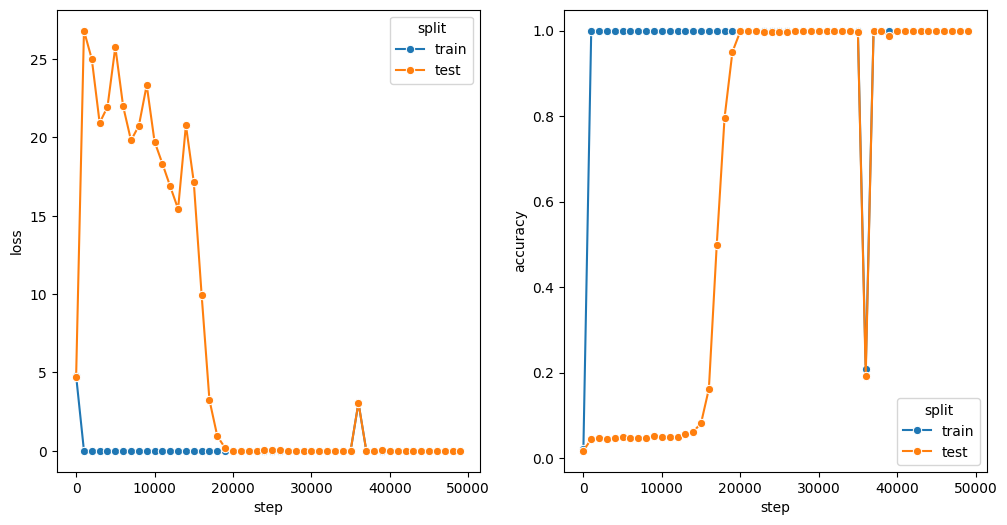

: 

In [8]:
df = pd.DataFrame(data)

df_loss = df[["step", "train_loss", "test_loss"]]
df_loss = df_loss.melt("step", var_name="split", value_name="loss")
df_loss["split"] = df_loss["split"].str.replace("_loss", "")


df_acc = df[["step", "train_acc", "test_acc"]]
df_acc = df_acc.melt("step", var_name="split", value_name="accuracy")
df_acc["split"] = df_acc["split"].str.replace("_acc", "")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=df_loss, x="step", y="loss", hue="split", marker="o", ax=axs[0])
sns.lineplot(data=df_acc, x="step", y="accuracy", hue="split", marker="o", ax=axs[1])